# Movie Recommender System

A recommender system is a system that attempts to predict the rating or preference a user would give to a certain item.
In this case, it is intended to create a movie recommender system.

A popular algorithm for these kind of systems is the Singular Value Decomposition (SVD), that has been utilized to achieve better results, as it will be demonstrated ahead.

## Dataset

The MovieLens Dataset is most often used for the purpose of recommender systems, which aim to predict user movie ratings based on other users’ ratings.

The dataset used was extracted from MovieLens and contains 100836 ratings and 3683 tag applications across 9742 movies. This data was created by 610 users between March 29, 1996 and September 24, 2018.

The data are contained in the files:
- Movies.csv: movieId, title, genres.
- Ratings.csv: userId, movieId, rating, timestamp.
- Tags.csv: userId, movieId, tag, timestamp.

In [58]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Data Analysis

In [59]:
# Read Movie Data
i_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item',  sep='|', names=i_cols, encoding='latin-1')

movies.head()

num_movies = len(movies)

print(num_movies)

1682


In [60]:
# user
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

users.head()

num_users = len(users)

print(num_users)

943


In [61]:
# Ratings
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

ratings.head()

ratings.describe()

print(len(ratings.user_id.unique()))
print(len(ratings.movie_id.unique()))

943
1682


## Sparsity

The Sparsity of a matrix is measured by the number of cells that do not have a value.
As it can be seen bellow, the matrix of ratings in this dataset is going to be very sparse, having a sparsity of 93.7%,
which means that the majority of users only rated a small percentage of the movies.

In [62]:
sparsity = 1 - len(ratings) / (num_users * num_movies)

print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


Data Analysis

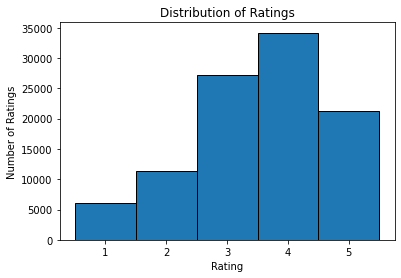

In [63]:
plt.hist(ratings.rating, ec='black', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

## Construct Matrix

In [64]:
ratings_matrix = ratings.pivot(index="user_id", columns="movie_id", values="rating")

print(ratings_matrix.shape)
print(ratings_matrix.iloc[:5, :5])

(943, 1682)
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  NaN  NaN  NaN  NaN
3         NaN  NaN  NaN  NaN  NaN
4         NaN  NaN  NaN  NaN  NaN
5         4.0  3.0  NaN  NaN  NaN


As it can be seen above, there are NaN entries on the matrix, which need to be replaced by some other value in order to perform the SVD.

There are several approaches to this problem, such as replacing with zero value, or average of all ratings, or even the average rating of a user.

In [65]:
ratings_matrix = ratings_matrix.fillna(0)
print(ratings_matrix.iloc[:5, :5])

movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0


The sparsity mentioned above, can be verified by the percentage of zeros present in the matrix.

In [66]:
sparsity = 1 - np.count_nonzero(ratings_matrix) / (num_users * num_movies)
print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# SVD

The SVD, Singular Value decomposition, its a technique that allows the factorization of the matrix data into a multiplication between three matrices, U, Sigma and V. The columns of the matrix U are considered the singular vectors on the left and the columns of the matrix V are the singular vectors on the right. Sigma has the singular values ​​diagonally.
SVD contains some important properties:
- It is always possible to decompose any matrix A into three matrices: U, Sigma and V.
- U, Sigma and V are always unique matrices, which means that a set of U, Sigma and V represents a single matrix A.
- U and V have orthonormal columns, which means that by multiplying the transpose of U with U, an identity matrix is ​​obtained.
- The sigma matrix is ​​diagonal, which means that all non-diagonal values ​​have zero value. The diagonal entries of this matrix are always positive, and by convention they are sorted in descending order. 

In [67]:
#TODO:
# Get a few data for tests and then replace on train matrix
# also do ratings_matrix = ratings_matrix.fillna(x) with x equal to the mean global rating
# and then predict for a trained rating and untrained rating

U, S, VT = np.linalg.svd(ratings_matrix, full_matrices=False)

print(f"U: {pd.DataFrame(U).iloc[:5, :5]}")
print(f"S: {pd.DataFrame(S).iloc[:5, :]}")
print(f"VT: {pd.DataFrame(VT).iloc[:5, :5]}")
print(U.shape)
print(S.shape)
print(VT.shape)

## SVD Matrix Reconstruction

The factorization of the matrixes U, Sigma and V will allow make an aproximation to the original matrix. Thus, we are able to reconstruct this matrix resulting in very small error values, as it is shown below. 

In [ ]:
reconstructed_matrix = np.dot(U * S, VT)

print(reconstructed_matrix[1][:4])
print(ratings_matrix.iloc[1, :4].to_numpy())

mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
mse = np.average((ratings_matrix - reconstructed_matrix) ** 2)
rmse = math.sqrt(mse)
print("Reconstruction Mean Absolute Error: ", mae)
print("Reconstruction Mean Square Error: ", mse)
print("Reconstruction Root Mean Square Error: ", rmse)

[4.00000000e+00 3.42524620e-13 2.72351586e-14 6.08471606e-14]
[4. 0. 0. 0.]
Reconstruction Mean Absolute Error:  1.850350696539756e-15
Reconstruction Mean Square Error:  1.0279565730740995e-29
Reconstruction Root Mean Square Error:  3.20617618523078e-15


## Truncated SVD
SVD establishes linear relationships between data that best describe them.
Through the singular values ​​obtained in the matrix S, which are indicators of the weight of each latent factor, we can choose R latent factors, which as the matrix is ​​ordered in descending order, we can only get the first values. This dimension reduction technique is called Truncated SVD.
Truncated SVD allows the increasing of the performance of the system, and also the reduction of the overfit of a trained model, since latent factors with little weight can be seen as noise.
We may reconstruct the matrix using 10 latent factors, for example, as it can be verified bellow. As expected the errors obtained are way higher than the previous ones.

In [ ]:
reconstructed_matrix = np.dot(U[:,:10] * S[:10], VT[:10,:])
mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
mse = np.average((ratings_matrix - reconstructed_matrix) ** 2)
rmse = math.sqrt(mse)
print("Reconstruction Mean Absolute Error: ", mae)
print("Reconstruction Mean Square Error: ", mse)
print("Reconstruction Root Mean Square Error: ", rmse)

Reconstruction Mean Absolute Error:  0.28828730113395534
Reconstruction Mean Square Error:  0.46087448189914654
Reconstruction Root Mean Square Error:  0.6788773688223423


Bruno pa baixo
## Funk SVD


Fetches dataset

Splits data

Trains with learning rate...

In [ ]:
%%capture
#retrieve dataset with 100k rows
df = fetch_ml_ratings(variant='100k')

train = df.sample(frac=0.8, random_state=7)
val = df.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = df.drop(train.index.tolist()).drop(val.index.tolist())

svd = SVD(lr=0.001, reg=0.005, n_epochs=100, n_factors=15, early_stopping=True,
          shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.17 - val_rmse: 1.08 - val_mae: 0.91 - took 0.0 sec
Epoch 2/100  | val_loss: 1.11 - val_rmse: 1.05 - val_mae: 0.88 - took 0.0 sec
Epoch 3/100  | val_loss: 1.07 - val_rmse: 1.03 - val_mae: 0.85 - took 0.0 sec
Epoch 4/100  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 5/100  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 6/100  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 7/100  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 8/100  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 9/100  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 10/100 | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 11/100 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 12/100 | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 13/100 | val

KeyError: 0

## MAE RMSE w/e

In [ ]:
pred = svd.predict(test)
mae = mean_absolute_error(test['rating'], pred)
msq = mean_squared_error(test['rating'], pred)
rmsq = math.sqrt(msq)
print(f'Test MAE: {mae:.2f}')
print(f'Test MSE: {msq:.2f}')
print(f'Test RMSE: {rmsq:.2f}')

Test MAE: 0.75
Test MSE: 0.90
Test RMSE: 0.95


## Hyperparameters Tunning

In [ ]:
%%capture
lrs = [0.0001, 0.001, 0.01, 0.1]
factors = [5, 10, 15, 20, 25, 30]

mae_outputs = {}
for lr in lrs:
	for n in factors:
		svd = SVD(lr=lr, n_epochs=100, n_factors=n, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

		svd.fit(X=train, X_val=val)

		pred = svd.predict(test)
		mae = mean_absolute_error(test['rating'], pred)
		mae_outputs.setdefault(lr, [])
		mae_outputs[lr].append(mae)

KeyboardInterrupt: 

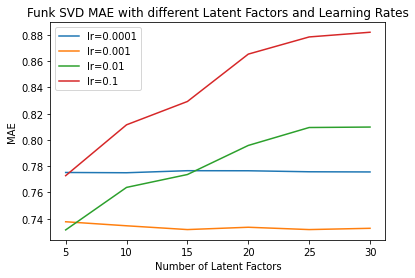

Optimal Learning Rate: 0.01
Optimal Number of Latent Factors: 5


In [ ]:
for lr in mae_outputs:
	plt.plot(factors, mae_outputs[lr], label=f"lr={lr}")

plt.ylabel("MAE")
plt.xlabel("Number of Latent Factors")
plt.xticks(factors)
plt.title("Funk SVD MAE with different Latent Factors and Learning Rates")
plt.legend()
plt.show()

opt_lr, lr_n_factors = min(mae_outputs.items(), key=lambda x: min(x[1]))
opt_n_factor = factors[lr_n_factors.index(min(lr_n_factors))]

print(f"Optimal Learning Rate: {opt_lr}")
print(f"Optimal Number of Latent Factors: {opt_n_factor}")


## Predict for a rating of a user for rated and non rated movies example

In [ ]:
%%capture
# Train SVD with optimal hyperparameters calculated previously
svd = SVD(lr=0.01, n_epochs=100, n_factors=10, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

In [ ]:
user_id_rated = train.iloc[0, :].u_id
movie_id_rated = train.iloc[0, :].i_id

user_id_unrated = test.iloc[0, :].u_id
movie_id_unrated = test.iloc[0, :].i_id

def predict(svd, user_id, movie_id):
	# initialize prediction to global mean rating
	pred = svd.global_mean_

	# getting index assigned to the user id by the Funk SVD
	u_ix = svd.user_mapping_[user_id]

	# adding the bias associated with this user id
	pred += svd.bu_[u_ix]

	# getting index assigned to the movie id by the Funk SVD
	i_ix = svd.item_mapping_[movie_id]

	# adding the bias associated with the movie id
	pred= pred + svd.bi_[i_ix]

	# dot product between the associated user's and movie's latent factors
	pred+= np.dot(svd.pu_[u_ix], svd.qi_[i_ix])

	return pred

print(f"Rating prediction for user {user_id_rated} of a rated movie (in training set) {movie_id_rated}: {predict(svd, user_id_rated, movie_id_rated):0.1f},\
 Actual Rating: {ratings_matrix.iloc[user_id_rated - 1, movie_id_rated - 1]}")
print(f"Rating prediction for user {user_id_unrated} of a unrated movie (not in training set) {movie_id_unrated}:\
 {predict(svd, user_id_unrated, movie_id_unrated):0.1f},\
 Actual Rating: {ratings_matrix.iloc[user_id_unrated - 1, movie_id_unrated - 1]}")

707 815
Rating prediction for user 707 of a rated movie (in training set) 815: 3.1, Actual Rating: 2.0
259 200
Rating prediction for user 259 of a unrated movie (not in training set) 200: 4.0, Actual Rating: 4.0


CHICO pa baixo
## Similarity Analysis

Calculate cosine similarity, sort by most similar and return the top N.

In [ ]:
def top_cosine_similarity(data, item_id, top_n=10):
    index = item_id - 1 #Ids starts from 1 in the dataset
    row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
        movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])

# Function to print top N similar users
def print_similar_users(user_data, user_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
        user_data[user_data.user_id == user_id]))
    for id in top_indexes + 1:
        print(user_data[user_data.user_id == id])


movie_id = 1
user_id = 1
top_n = 5
top_indexes_movies = top_cosine_similarity(VT, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

Recommendations for Toy Story (1995): 

Toy Story (1995)
Billy Madison (1995)
Aristocats, The (1970)
Much Ado About Nothing (1993)
GoldenEye (1995)


No handles with labels found to put in legend.


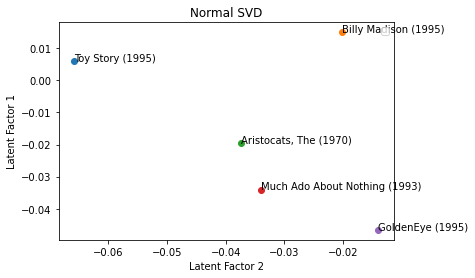

No handles with labels found to put in legend.


Recommendations for    user_id  age sex  occupation zip_code
0        1   24   M  technician    85711: 

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
     user_id  age sex  occupation zip_code
462      463   48   F  healthcare    75218
     user_id  age sex occupation zip_code
893      894   47   M   educator    74075
     user_id  age sex  occupation zip_code
621      622   25   M  programmer    14850
     user_id  age sex occupation zip_code
289      290   40   M   engineer    93550
Recommendations for Toy Story (1995): 

Toy Story (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Fan, The (1996)
Desperado (1995)
Air Bud (1997)


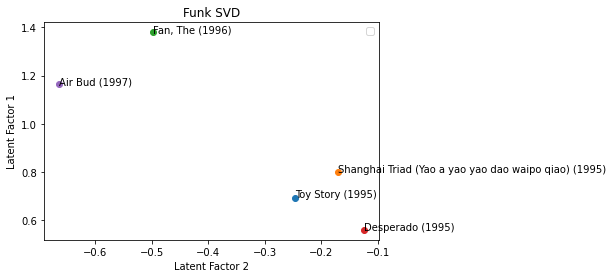

Recommendations for    user_id  age sex  occupation zip_code
0        1   24   M  technician    85711: 

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
     user_id  age sex  occupation zip_code
670      671   21   M  programmer    91919
     user_id  age sex occupation zip_code
201      202   41   F   educator    60201
     user_id  age sex occupation zip_code
616      617   27   F     writer    11201
     user_id  age sex occupation zip_code
442      443   35   M   salesman    33308


In [ ]:
for i in top_indexes_movies:
	plt.plot(U[i,0], U[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (U[i,0], U[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Normal SVD")
plt.legend()
plt.show()

top_indexes_users = top_cosine_similarity(U, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)



top_indexes_movies = top_cosine_similarity(svd.qi_, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

for i in top_indexes_movies:
	plt.plot(svd.qi_[i,0], svd.qi_[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (svd.qi_[i,0], svd.qi_[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Funk SVD")
plt.legend()
plt.show()

top_indexes_users = top_cosine_similarity(svd.pu_, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)